In [1]:
import numpy as np
import pandas as pd

"""
Comparison for network Lorenz stochastic dynamics inference

"""

# Import the package:

from StochasticForceInference import *

 

In [45]:
x_data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenzsingle_x_stochastic_gamma1.csv',encoding='utf-8',header=None)

In [46]:
T=100
dt=0.01
tlist=np.linspace(0.01,T,int(T/dt))

In [47]:
xlist = x_data.iloc[:,:3].values.reshape(-1,1,3)
print("check:")
print(xlist.shape)

check:
(10000, 1, 3)


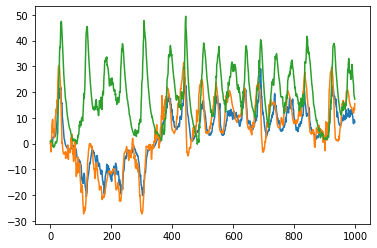

In [48]:
import matplotlib.pyplot as plt
plt.plot(xlist[:1000,0,:])

In [49]:
import numpy as np
import pandas as pd
import time
Start = time.time()
# Import the package:
from StochasticForceInference import *

 
################################################################
##### I. Prepare the data (here using a simulated model). ######


# # Diffusion parameters: a linear diffusion gradient (multiplicative noise)
# dim=3
# diffusion_coeff = 0.1
# D = diffusion_coeff *  np.identity(dim) 
# y = np.array([1.,2,1])
# D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# # Force field parameters (stochastic Lorenz process)
# r,b,s = 6.,1.,3.

# # force = lambda X : np.array([[ s*(x[2]-x[0]),
# #                                x[0]*x[2]-b*x[1],
# #                                r*x[0] - x[2] - x[1]*x[0]] for x in X ])

# # force = lambda X : np.array([[ 3*(x[1]-x[0]), 
# #                                 26.5*x[0]-x[1]-x[0]*x[2], 
# #                                 x[0]*x[1]-0.16*x[2] ]for x in X])

# # # Note: the "for" loop runs over particles/copies of the simulation;
# # #   it is not used here.

# # # Simulation parameters
# # initial_position = np.array([[0.1 for i in range(dim)]]) 
# dt = 0.01
# oversampling = 4
# # #prerun = 100
# Npts = 10000
# # tau = dt * Npts
# # tlist = np.linspace(0.,tau,Npts)

# # # Run the simulation using our OverdampedLangevinProcess class
# # np.random.seed(1)
# # X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling)

# # # Possibly blur a bit the data to mimic noise from the measurement
# # # device:
# # noise_amplitude = 0.0
# # noise = noise_amplitude * np.random.normal(size=X.data.shape)

# # # The input of the inference method is the "xlist" array, which has
# # # shape Nsteps x 1 x dim (the middle index is used for multiple
# # # particles with identical properties; we do not use it in this demo).
# # xlist = X.data + noise
# # tlist = X.t


xlist = xlist[:,0,:].reshape(-1,1,3)
print(xlist)
print(tlist)
print(xlist.shape, tlist.shape)



freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   #[start:stop:step]
center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()
End = time.time()
print("Time consuming:",End-Start)
#data_exact = StochasticTrajectoryData(X.data,X.t)

[[[ 3.2278e-03  8.9063e-01  7.2385e-01]]

 [[ 9.1814e-02 -1.3461e+00  6.4036e-01]]

 [[-4.9648e-02 -3.2322e+00  9.5121e-01]]

 ...

 [[ 7.5708e+00  1.0268e+01  2.3059e+01]]

 [[ 7.6586e+00  9.8978e+00  2.3696e+01]]

 [[ 7.0532e+00  1.0618e+01  2.2692e+01]]]
[1.000e-02 2.000e-02 3.000e-02 ... 9.998e+01 9.999e+01 1.000e+02]
(10000, 1, 3) (10000,)
1 3
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[ 85.75194165  16.05769427   2.89169942]
 [ 16.05769427 134.77435076   1.7627221 ]
 [  2.89169942   1.7627221  187.52849604]]
Entropy production: inferred/bootstrapped error 20138.574897651226 209.4687322616491
Drift information: inferred/bootstrapped error 6270.284192029164 112.98481483835927
Drift: squared typical error on projections: 0.014278518588011083
  - due to trajectory length: 0.0023922360678752205
  - due to discretization: 0.011886282520135863
Diffusion: squared typical error on projections: 6.296773792621571
  - due to trajectory length: 0.0036

In [50]:
data_exact = StochasticTrajectoryData(xlist,tlist)
print(data_exact)
F_exact = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenzsingle_F_gamma10.csv',encoding='utf-8',header=None)
F_exact1 = F_exact.values[1:-1,:].reshape(-1,1,3)
#S.compare_to_exact(data_exact=data_exact,force_exact=F_exact)

indices = np.array([i for i in range(0,len(tlist)-2,1)])
ansatz_F_Ito  = [ S.F_ansatz(data.X_ito[i]) for i in indices ]

# SFI_plotting_toolkit.comparison_scatter(F_exact1,ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
# plt.xlabel('exact F_mu(x)',labelpad=-1)
# plt.ylabel('inferred F_mu(x)',labelpad=0)

1 3


In [51]:
npdata=np.array(ansatz_F_Ito).reshape(-1,3)

In [52]:
# ygoal = ansatz_F_Ito[0]
# for t in range(npdata[:].shape[0]):
#     tmp = ansatz_F_Ito[t]
#     ygoal = np.vstack((ygoal,tmp))

In [53]:
"""Self library
   author: Ting-Ting Gao"""

import pandas as pd
import numpy as np
import itertools as it

def elementary_functions_name(dimensionList,order):
    Combination_func = list(it.combinations_with_replacement(dimensionList,order))
    Num_of_func = len(Combination_func)
    Name_of_func = []
    for i in range(0,Num_of_func):
        tmp = "".join(Combination_func[i])
        Name_of_func.append(tmp)
    return Num_of_func, Name_of_func

def self_ElementaryFunctions_Matrix(TimeSeries, dim, selfPolyOrder, PolynomialIndex = True, TrigonometricIndex = True, \
    ExponentialIndex = True, FractionalIndex = True, ActivationIndex = True):
    
    ElementaryMatrix = pd.DataFrame()
    if PolynomialIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix,Polynomial_functions(TimeSeries, dim, selfPolyOrder)],axis=1)
    if TrigonometricIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Trigonometric(TimeSeries, dim,Sin = True, Cos = True, Tan = True)],axis=1)
    if ExponentialIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Exponential(TimeSeries, dim, expomential = True)],axis=1)
    if FractionalIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Fractional(TimeSeries, dim, fractional = True)],axis=1)
    if ActivationIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Activation(TimeSeries, dim, Sigmoid = True, Tanh = True, Regulation = True)],axis=1)
    
    return ElementaryMatrix

def Polynomial_functions(TimeSeries, dim, PolyOrder):
    Timelength = np.size(TimeSeries, 0)
    dim_multi_Nnodes = np.size(TimeSeries, 1)

    if PolyOrder >= 1:
        if dim == 1:
            lst = ['x1']
            Numfunc, Namefunc = elementary_functions_name(lst,1)
            PolyOne = np.zeros(shape=(Timelength,Numfunc))
            for j in range(0,Numfunc):
                PolyOne[:,j]  = TimeSeries[:,j]
            column_values = Namefunc
            PolyOne = pd.DataFrame(data = PolyOne, columns = column_values)

        if dim == 2:
            lst = ['x1','x2']
            Numfunc, Namefunc = elementary_functions_name(lst,1)
            PolyOne = np.zeros(shape=(Timelength,Numfunc))
            for j in range(0,Numfunc):
                PolyOne[:,j]  = TimeSeries[:,j]
            column_values = Namefunc
            PolyOne = pd.DataFrame(data = PolyOne, columns = column_values) 
        
        if dim == 3:
            lst = ['x1','x2','x3']
            Numfunc, Namefunc = elementary_functions_name(lst,1)
            PolyOne = np.zeros(shape=(Timelength,Numfunc))
            for j in range(0,Numfunc):
                PolyOne[:,j]  = TimeSeries[:,j]
            column_values = Namefunc
            PolyOne = pd.DataFrame(data = PolyOne, columns = column_values)

        if dim == 4:
            lst = ['x1','x2','x3','x4']
            Numfunc, Namefunc = elementary_functions_name(lst,1)
            PolyOne = np.zeros(shape=(Timelength,Numfunc))
            for j in range(0,Numfunc):
                PolyOne[:,j]  = TimeSeries[:,j]
            column_values = Namefunc
            PolyOne = pd.DataFrame(data = PolyOne, columns = column_values)


    if PolyOrder >= 2:
        if dim == 1:
            lst = ['x1']
            Numfunc, Namefunc = elementary_functions_name(lst,2)
            PolyTwo = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            PolyTwo[:,j] = TimeSeries[:,j]**2
            column_values = Namefunc
            PolyTwo = pd.DataFrame(data = PolyTwo, columns = column_values)

        if dim == 2:
            lst = ['x1','x2']
            Numfunc, Namefunc = elementary_functions_name(lst,2)
            PolyTwo = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    PolyTwo[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]
                    j = j+1
            column_values = Namefunc
            PolyTwo = pd.DataFrame(data = PolyTwo, columns = column_values)

        if dim == 3:
            lst = ['x1','x2','x3']
            Numfunc, Namefunc = elementary_functions_name(lst,2)
            PolyTwo = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    PolyTwo[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]
                    j = j+1
            column_values = Namefunc
            PolyTwo = pd.DataFrame(data = PolyTwo, columns = column_values)

        if dim == 4:
            lst = ['x1','x2','x3','x4']
            Numfunc, Namefunc = elementary_functions_name(lst,2)
            PolyTwo = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    PolyTwo[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]
                    j = j+1
            column_values = Namefunc
            PolyTwo = pd.DataFrame(data = PolyTwo, columns = column_values)

        
    if PolyOrder >= 3:
        if dim == 1:
            lst = ['x1']
            Numfunc, Namefunc = elementary_functions_name(lst,3)
            PolyThree = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        PolyThree[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]
                        j = j+1
            column_values = Namefunc
            PolyThree = pd.DataFrame(data = PolyThree, columns = column_values)

        if dim == 2:
            lst = ['x1','x2']
            Numfunc, Namefunc = elementary_functions_name(lst,3)
            PolyThree = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        PolyThree[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]
                        j = j+1
            column_values = Namefunc
            PolyThree = pd.DataFrame(data = PolyThree, columns = column_values)

        if dim == 3:
            lst = ['x1','x2','x3']
            Numfunc, Namefunc = elementary_functions_name(lst,3)
            PolyThree = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        PolyThree[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]
                        j = j+1
            column_values = Namefunc
            PolyThree = pd.DataFrame(data = PolyThree, columns = column_values)

        if dim == 4:
            lst = ['x1','x2','x3','x4']
            Numfunc, Namefunc = elementary_functions_name(lst,3)
            PolyThree = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        PolyThree[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]
                        j = j+1
            column_values = Namefunc
            PolyThree = pd.DataFrame(data = PolyThree, columns = column_values)

    if PolyOrder >= 4:
        if dim == 1:
            lst = ['x1']
            Numfunc, Namefunc = elementary_functions_name(lst,4)
            PolyFour = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        for ll in range(kk,dim):
                            PolyFour[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]*TimeSeries[:,ll]
                            j = j+1
            column_values = Namefunc
            PolyFour = pd.DataFrame(data = PolyFour, columns = column_values)

        if dim == 2:
            lst = ['x1','x2']
            Numfunc, Namefunc = elementary_functions_name(lst,4)
            PolyFour = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        for ll in range(kk,dim):
                            PolyFour[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]*TimeSeries[:,ll]
                            j = j+1
            column_values = Namefunc
            PolyFour = pd.DataFrame(data = PolyFour, columns = column_values)

        if dim == 3:
            lst = ['x1','x2','x3']
            Numfunc, Namefunc = elementary_functions_name(lst,4)
            PolyFour = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        for ll in range(kk,dim):
                            PolyFour[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]*TimeSeries[:,ll]
                            j = j+1
            column_values = Namefunc
            PolyFour = pd.DataFrame(data = PolyFour, columns = column_values)

        if dim == 4:
            lst = ['x1','x2','x3','x4']
            Numfunc, Namefunc = elementary_functions_name(lst,4)
            PolyFour = np.zeros(shape=(Timelength,Numfunc))
            j = 0
            for ii in range(0,dim):
                for jj in range(ii,dim):
                    for kk in range(jj,dim):
                        for ll in range(kk,dim):
                            PolyFour[:,j] = TimeSeries[:,ii]*TimeSeries[:,jj]*TimeSeries[:,kk]*TimeSeries[:,ll]
                            j = j+1
            column_values = Namefunc
            PolyFour = pd.DataFrame(data = PolyFour, columns = column_values)
    if PolyOrder == 1:
        return PolyOne
    if PolyOrder == 2:
        return pd.concat([PolyOne, PolyTwo], axis=1)
    if PolyOrder == 3:
        return pd.concat([PolyOne, PolyTwo, PolyThree], axis=1)
    if PolyOrder == 4:
        return pd.concat([PolyOne, PolyTwo, PolyThree, PolyFour], axis=1)

def Trigonometric(TimeSeries, dim, Sin = True, Cos = True, Tan = True):
    Timelength = np.size(TimeSeries, 0)
    dim_multi_Nnodes = np.size(TimeSeries, 1)

    if Sin == True:
        sine = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            sine[:,j] = np.sin(TimeSeries[:,j])
        if dim == 1:
            column_values = ['sinx1']
        if dim == 2:
            column_values = ['sinx1','sinx2']
        if dim == 3:
            column_values = ['sinx1','sinx2','sinx3']
        if dim == 4:
            column_values = ['sinx1','sinx2','sinx3','sinx4']
        sine = pd.DataFrame(data = sine, columns = column_values)

    if Cos == True:
        cosine = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            cosine[:,j] = np.cos(TimeSeries[:,j])
        if dim == 1:
            column_values = ['cosx1']
        if dim == 2:
            column_values = ['cosx1','cosx2']
        if dim == 3:
            column_values = ['cosx1','cosx2','cosx3']
        if dim == 4:
            column_values = ['cosx1','cosx2','cosx3','cosx4']
        cosine = pd.DataFrame(data = cosine, columns = column_values)

    if Tan == True:
        tangent = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            tangent[:,j] = np.tan(TimeSeries[:,j])
        if dim == 1:
            column_values = ['tanx1']
        if dim == 2:
            column_values = ['tanx1','tanx2']
        if dim == 3:
            column_values = ['tanx1','tanx2','tanx3']
        if dim == 4:
            column_values = ['tanx1','tanx2','tanx3','tanx4']
        tangent= pd.DataFrame(data = tangent, columns = column_values)
    return pd.concat([sine, cosine, tangent], axis=1)

def Exponential(TimeSeries, dim, expomential = True):
    Timelength = np.size(TimeSeries, 0)
    dim_multi_Nnodes = np.size(TimeSeries, 1)
    if expomential == True:
        Exp = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            Exp[:,j] = np.exp(TimeSeries[:,j])
        if dim == 1:
            column_values = ['expx1']
        if dim == 2:
            column_values = ['expx1','expx2']
        if dim == 3:
            column_values = ['expx1','expx2','expx3']
        if dim == 4:
            column_values = ['expx1','expx2','expx3','expx4']
        Exp = pd.DataFrame(data = Exp, columns = column_values)
    return Exp

def Fractional(TimeSeries, dim, fractional = True):
    Timelength = np.size(TimeSeries, 0)
    dim_multi_Nnodes = np.size(TimeSeries, 1)
    if fractional == True:
        frac = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            frac[:,j] = 1/TimeSeries[:,j]
        if dim == 1:
            column_values = ['fracx1']
        if dim == 2:
            column_values = ['fracx1','fracx2']
        if dim == 3:
            column_values = ['fracx1','fracx2','fracx3']
        if dim == 4:
            column_values = ['fracx1','fracx2','fracx3','fracx4']
        frac = pd.DataFrame(data = frac, columns = column_values)
    return frac

def Activation(TimeSeries, dim, Sigmoid = True, Tanh = True, Regulation = True):
    Timelength = np.size(TimeSeries, 0)
    dim_multi_Nnodes = np.size(TimeSeries, 1)
    if Sigmoid == True:
        #alpha = np.linspace(1,10,10)
        alpha = [1, 5, 10]
        #beta = np.linspace(0,10,11)
        beta = [0,1, 5, 10]
        Numfunc = len(alpha)*len(beta)
        sigmoid = np.zeros(shape=(Timelength,dim*Numfunc))
        kk = 0
        for j in range(0,dim):
            for ii in range(0,len(alpha)):
                for jj in range(0,len(beta)):
                    sigmoid[:,kk] = 1./(1.+np.exp(-alpha[ii]*(TimeSeries[:,j]-beta[jj])))
                    kk = kk+1
        kk = 0
        Sigmoid = pd.DataFrame()
        for j in range(0,dim):
            for ii in range(0,len(alpha)):
                for jj in range(0,len(beta)):
                    tmp = ["sig_x"+str(j+1)+"_"+str(alpha[ii])+str(beta[jj])]
                    tmp_2 = pd.DataFrame(data = sigmoid[:,kk], columns = tmp)
                    kk = kk+1
                    Sigmoid = pd.concat([Sigmoid,tmp_2], axis=1)
    
    if Tanh == True:
        tanh = np.zeros(shape=(Timelength,dim))
        for j in range(0,dim):
            tanh[:,j] = (np.exp(TimeSeries[:,j])-np.exp(-TimeSeries[:,j]))/(np.exp(TimeSeries[:,j])+np.exp(-TimeSeries[:,j]))
        if dim == 1:
            column_values = ['tanhx1']
        if dim == 2:
            column_values = ['tanhx1','tanhx2']
        if dim == 3:
            column_values = ['tanhx1','tanhx2','tanhx3']
        if dim == 4:
            column_values = ['tanhx1','tanhx2','tanhx3','tanhx4']
        tanh = pd.DataFrame(data = tanh, columns = column_values)

    if Regulation == True:
        #gamma = np.linspace(0,10,11)
        gamma = [1,2,5,10]
        Numfunc = len(gamma)
        regulation = np.zeros(shape=(Timelength,dim*Numfunc))
        kk = 0
        for j in range(0,dim):
            for ii in range(0,len(gamma)):
                    regulation[:,kk] = (TimeSeries[:,j]**gamma[ii])/(TimeSeries[:,j]**gamma[ii]+1)
                    kk = kk+1

        kk = 0
        Regulation = pd.DataFrame()
        for j in range(0,dim):
            for ii in range(0,len(gamma)):
                tmp = ["regx"+str(j+1)+"_"+str(gamma[ii])]
                tmp_2 = pd.DataFrame(data = regulation[:,kk], columns = tmp)
                kk = kk+1
                Regulation = pd.concat([Regulation,tmp_2], axis=1)
    return pd.concat([Sigmoid, tanh, Regulation], axis=1)

In [54]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     print(reg.coef_)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [55]:
data = x_data.iloc[:,:3].values.reshape(-1,3)
Matrix = self_ElementaryFunctions_Matrix(data, 3, 3, PolynomialIndex = True, TrigonometricIndex = True, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = False)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [56]:
Matrix = Matrix.iloc[1:-1,:]

In [57]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,0])

In [58]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9998422223255573
Best threshold: 0.001


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 without constant.
x2x2x3     0.000108
x1x2x3    -0.000865
x1x1x3     0.000961
x1x3      -0.014386
x1x1       0.015510
x3        -0.019337
x2x2       0.021596
x1x2      -0.035307
x2         9.892298
x1       -11.631715
dtype: float64


In [60]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,1])
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

0.99898802846304
Best threshold: 0.002
Elementary functions discovered by Phase 1 without constant.
x2x2x2    -0.000165
x1x1x3     0.000186
x1x1x2     0.000241
x2x2      -0.000565
x1x3x3    -0.001611
x2x3      -0.014048
x3        -0.260926
x1x3      -0.597362
x2        -1.851262
x1        18.299666
dtype: float64


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [61]:
X = Matrix.copy()
y = npdata.copy()
X_mat = X.values 
y_mat = npdata
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,2])
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

0.9999277066469848
Best threshold: 0.001
Elementary functions discovered by Phase 1 without constant.
x2x3x3   -0.000063
x2x2x3   -0.000197
x1x2x3    0.000453
x1x3     -0.002585
x3x3     -0.007332
x2x2     -0.013375
x1x1      0.018818
x2        0.114869
x1x2      0.507167
x3       -3.294475
dtype: float64


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
